<a href="https://colab.research.google.com/github/Svensone/kaggle/blob/main/04_04_21_%5Bfastai%5D_JPG_Melanoma_CV_Vers_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIIM-ISIC Melanoma Classification


- Training a ResNet34 Model with pytorch/fastai
- Dataset: 33.126 / 32.531 Images (after cleaning Jpeg files(512x512) of lung scans
- Prediction: pneumonia / normal (healty)*italicized text*

Vers. 4
* callbacks added
* more training

### 1. Setup

In [ ]:
# update fastai to Version 2.0
!pip install fastai --upgrade
!pip install fastcore

     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 225kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
# add this to console so colab does not disconnect since idle

# function KeepClicking(){
#    console.log("Clicking");
#    document.querySelector("colab-toolbar-button#connect").click()
# }setInterval(KeepClicking,60000)

In [ ]:
!pip install -Uqq fastbook

import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 18.5MB/s 
     |████████████████████████████████| 1.2MB 53.5MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
Mounted at /content/gdrive


In [ ]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# import necessary libaries
#basics
import pandas as pd
import numpy as np
import random, os

# ML
import fastcore
import fastai
from fastai.vision.all import *
from fastai.data.all import *
from fastai.basics import *
from fastai.callback.all import *

import fastcore, torch, torchvision

# Data Exploration / Visualization
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [ ]:
#check versions
# print("GPU available", torch.cuda.is_available())
# print(" GPU", torch.cuda.get_device_name(0))
# print("GPU ", torch.backends.cudnn.enabled)
print('Numpy        :', np.__version__)
print('fastai      :', fastai.__version__)
print('And torch version ',torch.__version__)
print(f'fastcore version {fastcore.__version__} installed.')

Numpy        : 1.19.5
fastai      : 2.3.0
And torch version  1.7.1
fastcore version 1.3.19 installed.


In [ ]:
## for reproducability set seed
def seed_everything(seed=0):
  random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
seed_everything()

In [ ]:
# add this to console so colab does not disconnect since idle

# function KeepClicking(){
#    console.log("Clicking");
#    document.querySelector("colab-toolbar-button#connect").click()
# }setInterval(KeepClicking,60000)

Setup GDrive and **Kaggle**

In [ ]:
# # connect kaggle
# from google.colab import files
# files.upload()

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


## 2. Data



#### 2.1 get data

In [ ]:
##### UNCOMMMENT FIRST TIME ############
### Get partial Data (since Dataset w. 100+GB to big)

# !kaggle competitions list -s siim
# # workaround to download only part of dataset

## downlaod subfolder with jpeg train set
# !wget https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/20270/1222630/compressed/jpeg.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1593154735&Signature=FZyxMM0gZdIUqSMim4RFDokpybUAQx1YBVLikKu5OuZyvRjyWq4e5X0HhX%2B0NMDYucFjI3ZZwPhLMp81IDJw2rNvRrrkCypzw%2F15CGCneXhhQrjWwK%2F0Mj%2BK0e74i0%2FBh4WsYPczhEZwxFUsSRAIXHPNqPAYHpaWpw74ZQd7Nv9UV4ERypps2Aa7lVz13WIbmSMu1Bc0C4SZYUPCcIWqaS2nxe7ZlwzNISzJImr7FmyD7polCUWLyQMsqftAFrodma2mjXAIstMf2E6Sg6r3lFpRWKMRJO1oK8KFEOyO4lAk3jPdQDzjQwlYljxE1MRZDpRc9sV1CCFZwh5dgbmPHA%3D%3D&response-content-disposition=attachment%3B+filename%3Djpeg.zip

# !kaggle competitions download -c "siim-isic-melanoma-classification" -p 'sample_data/melanoma-data' -f test.csv
# !kaggle competitions download -c "siim-isic-melanoma-classification" -p 'sample_data/melanoma-data' -f train.csv
# !kaggle competitions download -c "siim-isic-melanoma-classification" -p 'sample_data/melanoma-data' -f sample_submission.csv

In [ ]:
# download jpeg img with 512 size
# !kaggle datasets download -d itacdonev/siim-isic-melanoma-classification-jpeg512

In [ ]:
##### UNCOMMMENT FIRST TIME ############

# #  unzip images 

# import zipfile
# images = Path('/content/drive/My Drive/Colab Notebooks/kaggle/melanoma/images_512/siim-isic-melanoma-classification-jpeg512.zip')

# with zipfile.ZipFile(images, 'r') as zip_ref:
#   zip_ref.extractall(path_512)


In [ ]:
# # create folder to save models
# !pwd
# !mkdir -p models
# !ls

### 2.2 test data

In [ ]:
##### UNCOMMMENT FIRST TIME ############
### run the first time to download data
!pwd
%cd gdrive/My Drive/Colab Notebooks/kaggle/melanoma/images_512

/content
/content/gdrive/My Drive/Colab Notebooks/kaggle/melanoma/images_512


In [ ]:
!ls

models		       sample_submission.csv  test.csv	train.csv
resnet34-melanoma.pkl  test		      train


In [ ]:
path_512 = Path('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/images_512')

In [ ]:
path_train = os.path.join(path_512, 'train')
print(path_train)
# /content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/images_512/train

/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/images_512/train


In [ ]:
files = os.listdir(path_train)
len(files)

33126

In [ ]:
# check if only jpg in folders
assert len(glob.glob('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/images_512/train/*.jpg')) == len(os.listdir(path_512/'train'))
assert len(glob.glob('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/images_512/test/*.jpg')) == len(os.listdir(path_512/'test'))


In [ ]:
train_df = pd.read_csv(path_512/'train.csv')
# test_df = pd.read_csv(path_512/'test.csv')
# submission_df = pd.read_csv(path_512/'sample_submission.csv')
train_df.head()
print(f'df before deleting Nan : {train_df.shape}')
train_df = train_df.dropna()
print(f'After dropping Nan values: {train_df.shape}')

df = train_df.drop(columns=['patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant'])
print(df.shape)
df.head()

df before deleting Nan : (33126, 8)
After dropping Nan values: (32531, 8)
(32531, 2)


,image_name,target
0,ISIC_2637011,0
1,ISIC_0015719,0
2,ISIC_0052212,0
3,ISIC_0068279,0
4,ISIC_0074268,0


### 2.3 Prepare Data for Model

In [ ]:
# Create data block

In [ ]:
#replace lambda func since can"t export

def get_x(fname):
  path_x = os.path.join(path_train, f"{fname[0]}.jpg")
  return path_x
def get_y(fname):
  return fname[1]
# get_y = ColReader('target')

melanomaBlock = DataBlock(blocks=(ImageBlock(), CategoryBlock),
                          get_x = get_x,
                          get_y = get_y,
                          batch_tfms=[*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.), 
                                      Normalize.from_stats(*imagenet_stats)]
                          )

In [ ]:
dls = melanomaBlock.dataloaders(df.sample(200).values)
# dls.show_batch(max_n=16)

In [ ]:
# move dataloader to GPU
dls = dls.cuda()
dls

In [ ]:
# check data
print(dls.c, len(dls.train_ds), len(dls.valid_ds), dls.bs)

2 160 40 64


In [ ]:
# check batch
xb, yb = dls.one_batch()
print(f'Input shape: {xb.shape}, target shape: {yb.shape}.')

Input shape: torch.Size([64, 3, 512, 512]), target shape: torch.Size([64]).


## 3. Model



### 3.1 Create & Train Model

March 2021:
#######################

on Colab with GPU:
full dataset, resize(224), batch_tfms=[*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),Normalize.from_stats(*imagenet_stats)
- 1 epoch: 10min

no GPU:
-lr_find(): 10hr

In [ ]:
# define parameters

metrics = accuracy
wd = 1e-2
cbs = ShowGraphCallback()

learn = cnn_learner(dls, 
                    models.resnet34, 
                    normalize=True, 
                    n_out=None, 
                    pretrained=True, 
                    config=None, 
                    loss_func=None, 
                    opt_func=Adam, 
                    lr=0.001, 
                    splitter=None, 
                    cbs= cbs, 
                    metrics=metrics, 
                    path=None, 
                    model_dir='models', 
                    wd=wd, 
                    wd_bn_bias=False, 
                    train_bn=True, 
                    moms=(0.95, 0.85, 0.95), 
                    cut=None, n_in=3, 
                    custom_head=None, concat_pool=True, 
                    lin_ftrs=None, ps=0.5, first_bn=True, 
                    bn_final=False, lin_first=False, 
                    y_range=None)

In [ ]:
# if GPU enabled:
if torch.cuda.is_available():
    learn.model.cuda()

In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

epoch,train_loss,valid_loss,accuracy,time
0,1.206713,4.014110,0.000000,00:16


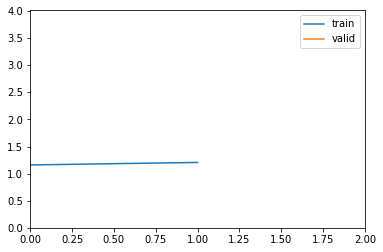

In [ ]:
learn.fit_one_cycle(1)

In [ ]:
learn.export('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/images_512/models/3mela_jpg.pkl')

In [ ]:
# load pretrained Model from Version 1
learn.load('melanoma_resnet34-stage2')

epoch,train_loss,valid_loss,accuracy,time
0,0.114180,0.121784,0.950000,00:05


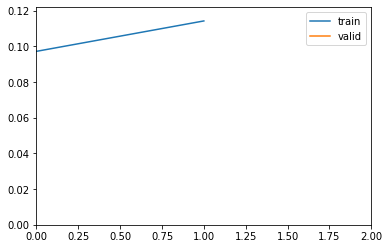

In [ ]:
# learn.lr_find()

In [ ]:
# lr = 10e-2
# learn.fit_one_cycle(5, slice(lr), cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2))

In [ ]:
# learn.save('melanoma_resnet34-stage1')

In [ ]:
learn.export('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/images_512/models/mela_jpg.pkl')

### 3.2 Additional Traininf

In [ ]:
learn.unfreeze()
# learn.lr_find()

In [ ]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.save('melanoma_resnet34-stage3')

Path('models/melanoma_resnet34-stage2.pth')

In [ ]:
learn.export('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/images_512/models/mela_jpg.pkl')

### 3.2 Evaluation Model

In [ ]:
test_img = path_512/'test/ISIC_9071525.jpg'
learn.predict(test_img)

('0', tensor(0), tensor([9.9998e-01, 1.6645e-05]))

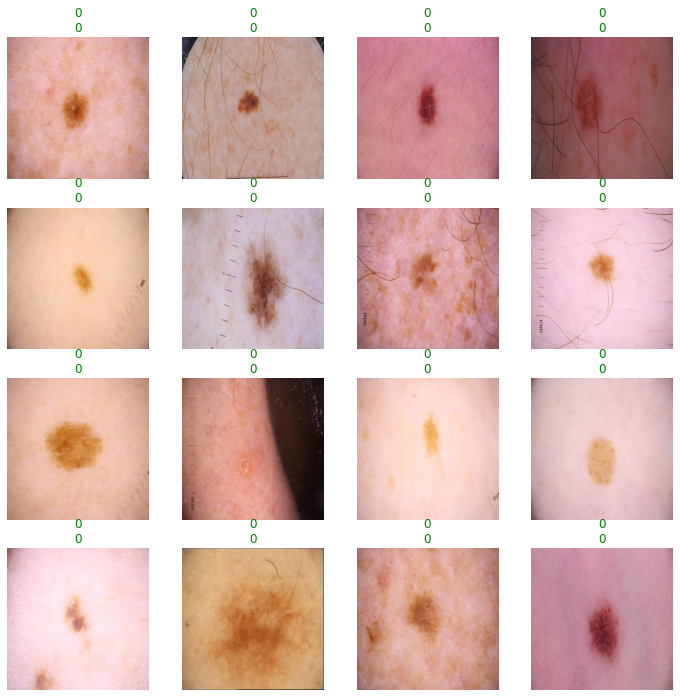

In [ ]:
learn.show_results(max_n=16)

In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(4)

In [ ]:
# crash after using all RAM
###########################

# class_interp = ClassificationInterpretation.from_learner(learn)
# losses,idxs = class_interp.top_losses()
# len(dls.valid_ds)==len(losses)==len(idxs)
# class_interp.plot_confusion_matrix(figsize=(7,7))

In [ ]:
# # calculate Sensitivity and Spec.
# upp, low = class_interp.confusion_matrix()
# tn, fp = upp[0], upp[1]
# fn, tp = low[0], low[1]
# print(tn, fp, fn, tp)

# sensit = tp / (tp + fn)
# specif = tn / (tn + fp)

# print(f'Sensitivity is : {sensit}, Specificity is : {speci}')

### 3.3 Test model

In [ ]:
# test image
test_files = os.listdir(path_512/'test512')
test_files[1]
test_img = path_512/'test512/ISIC_9071525.jpg'

pred_class, pred_idx, outputs = learn.predict(test_img)
# prob_malignant = float(outputs[1]) if str(pred_class) == 'benign' else float(outputs[0])

print(pred_class)
print(outputs)

train512
tensor([0.1772, 0.8228])


### 4. Create Submission to Kaggle

In [ ]:
# create submission.csv with image_name and target (float)

# get test image names and sort according to number of image_name
test = os.listdir(path_512/'test512')
test.sort(key=lambda f: int(re.sub('\D', '', f)))

# create submission.csv
with open('/submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_name', 'target'])
    
    for image_file in test:
        image = os.path.join((path_512/'test512'), image_file)  # change dir
        image_name = Path(image).stem

        pred_class, pred_idx, outputs = learn.predict(image)
        target = float(outputs[1])
        writer.writerow([image_name, target])

In [ ]:
# check submission file
sub_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/melanoma/images_512/sample_submission.csv')

print(f'submission file has the shape of : {sub_df.shape}')
# if differing - check with the dropped files (the NaN Values)
len(sub_df.target ==1)

10982

In [ ]:
# submit to kaggle

# kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m "Message"  ### from kaggle
# !kaggle competitions submit -c siim-isic-melanoma-classification -f '/content/drive/My Drive/Colab Notebooks/kaggle/melanoma/submission.csv' -m 'first submit'